 # Corporacion Favorita Sales Forecasting
        

In [33]:
# Import Requried Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
import os
print (os.listdir('./data'))

['merged.csv', 'test.csv', 'train.csv', 'transactions.csv', 'items.csv', 'oil.csv', 'holidays_events.csv', 'sample_submission.csv', 'stores.csv']


### Analysis of Calendar  and event information

Here we load the holidays and events information and merge the information with the transactions in order to see if there is a corelation between sales and holidays and events. The holidays_events data file has 350 individual days. There are 6 unique events that indicate if a particular day was either a work day or holiday. Some of these days are also categorized as "Bridge", Transfer and Additional days. Analysis of this data indicates that days are combined to enable people to have longer duration of holidays to ensure work life balance.Analyzing the holiday and events indicate that there are 12 holidays that were transferred to subsequent days. These holidays are either local or national holidays as mentioned by the column 'locale'. This information is relevant because we would like to merge the holiday information with the dataset to see if there is a corelation of sales to holidays. Normally we would expect sales to be higher during the holiday(s).

In [34]:
chunk_list=[]
chunk=10000000
types_dict = {'id': 'int32',
             'item_nbr': 'int32',
             'store_nbr': 'int8',
             'unit_sales': 'float32'}
df_chunk=pd.read_csv('./data/train.csv',usecols=[1,2,3,4,5],parse_dates=True,chunksize=chunk,iterator=True,na_values='nan',low_memory=True,dtype=types_dict)
chunk_list.append(df_chunk)
for chunk in chunk_list:
    df_t = pd.concat(chunk)
    

/Users/Ramki/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 5 columns):
date           object
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    object
dtypes: float32(1), int32(1), int8(1), object(2)
memory usage: 2.9+ GB


In [36]:
df_t.date=pd.to_datetime(df_t.date,format='%Y-%m-%d')

### From the training set, we only extract the sales for 1 year 2017 into a new data frame to avoid frequent crash of the kernel.

In [37]:
df_train_2017=df_t[(df_t['date']>='2017-01-01') & (df_t['date']<='2017-12-31')]

In [38]:
del df_t  ### Save Memory

In [39]:
df_train_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23808261 entries, 101688779 to 125497039
Data columns (total 5 columns):
date           datetime64[ns]
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    object
dtypes: datetime64[ns](1), float32(1), int32(1), int8(1), object(1)
memory usage: 749.3+ MB


In [40]:
df_train_2017.onpromotion=df_train_2017['onpromotion'].fillna(-1).astype(int)

In [41]:
df_train_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23808261 entries, 101688779 to 125497039
Data columns (total 5 columns):
date           datetime64[ns]
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    int64
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1), int8(1)
memory usage: 749.3 MB


In [42]:
df_train_2017.head(10)

,date,store_nbr,item_nbr,unit_sales,onpromotion
101688779,2017-01-01,25,99197,1.0,0
101688780,2017-01-01,25,103665,7.0,0
101688781,2017-01-01,25,105574,1.0,0
101688782,2017-01-01,25,105857,4.0,0
101688783,2017-01-01,25,106716,2.0,0
101688784,2017-01-01,25,108698,2.0,0
101688785,2017-01-01,25,108786,1.0,0
101688786,2017-01-01,25,108797,1.0,0
101688787,2017-01-01,25,108862,1.0,0
101688788,2017-01-01,25,108952,2.0,0


#### Here we merge the information from the stores.csv so that we can use the cluster information to compute statistics. First we set the store_nbr as index in the df_t data frame and then we merge the stores on store_nbr

In [43]:
df_stores=pd.read_csv('./data/stores.csv')

In [44]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Feature Engineering on Stores data set. Here we use Pandas get_dummies feature to create the stores on type and cluster. Before this we drop city, state from the data set

In [45]:
df_stores=df_stores.drop(['city','state','cluster'],axis=1)

In [46]:
df_store_features=pd.get_dummies(df_stores)

In [47]:
df_store_features.head(20)

,store_nbr,type_A,type_B,type_C,type_D,type_E
0,1,0,0,0,1,0
1,2,0,0,0,1,0
2,3,0,0,0,1,0
3,4,0,0,0,1,0
4,5,0,0,0,1,0
5,6,0,0,0,1,0
6,7,0,0,0,1,0
7,8,0,0,0,1,0
8,9,0,1,0,0,0
9,10,0,0,1,0,0


We create the index on store_nbr on the features data set and will merge this later to the sales data set

In [48]:
df_store_features=df_store_features.set_index('store_nbr')
df_train_2017=df_train_2017.set_index('store_nbr')
df_merged = df_train_2017.join(df_store_features,on='store_nbr',how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23808261 entries, 25 to 54
Data columns (total 9 columns):
date           datetime64[ns]
item_nbr       int32
unit_sales     float32
onpromotion    int64
type_A         uint8
type_B         uint8
type_C         uint8
type_D         uint8
type_E         uint8
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1), uint8(5)
memory usage: 840.1 MB


### Code 10/23/2019 ###
Here we delete df_t and df_stores dataframes to reclaim memory as the dataframe df_merged contains both training data and stores data

In [49]:
del df_train_2017
del df_stores

In [50]:
df_merged=df_merged.reset_index()  ## Reset index here so we can later add date as index

In [51]:
df_merged.head(10)

,store_nbr,date,item_nbr,unit_sales,onpromotion,type_A,type_B,type_C,type_D,type_E
0,25,2017-01-01,99197,1.0,0,0,0,0,1,0
1,25,2017-01-01,103665,7.0,0,0,0,0,1,0
2,25,2017-01-01,105574,1.0,0,0,0,0,1,0
3,25,2017-01-01,105857,4.0,0,0,0,0,1,0
4,25,2017-01-01,106716,2.0,0,0,0,0,1,0
5,25,2017-01-01,108698,2.0,0,0,0,0,1,0
6,25,2017-01-01,108786,1.0,0,0,0,0,1,0
7,25,2017-01-01,108797,1.0,0,0,0,0,1,0
8,25,2017-01-01,108862,1.0,0,0,0,0,1,0
9,25,2017-01-01,108952,2.0,0,0,0,0,1,0


In [52]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23808261 entries, 0 to 23808260
Data columns (total 10 columns):
store_nbr      int64
date           datetime64[ns]
item_nbr       int32
unit_sales     float32
onpromotion    int64
type_A         uint8
type_B         uint8
type_C         uint8
type_D         uint8
type_E         uint8
dtypes: datetime64[ns](1), float32(1), int32(1), int64(2), uint8(5)
memory usage: 840.1 MB


### Function to add categorical values "weekday

#### Add if the day is either a week day or week end based on the date to the data frame. This will be later used to compare sales for the specific periods.

In [53]:
df_merged=df_merged.reset_index()

df_merged['Day']=df_merged['date'].dt.day_name().astype(str)

df_merged['Day']=df_merged['Day'].astype('str')

df_merged=pd.get_dummies(df_merged)


### Now add the price of oil from oil.csv to the merged data frame

In [54]:
df_oil=pd.read_csv('./data/oil.csv',parse_dates=True)

df_oil['date'] = pd.to_datetime(df_oil.date,format='%Y-%m-%d')

df_oil=df_oil.set_index('date')

df_merged=df_merged.set_index('date')
df_merged=df_merged.join(df_oil,on='date',how='left')

In [59]:
df_merged['dcoilwtico']=df_merged['dcoilwtico'].fillna(method='bfill')
df_merged=df_merged.reset_index()

df_merged.set_index(['date','store_nbr','item_nbr'],inplace=True)

In [60]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23808261 entries, (2017-01-01 00:00:00, 25, 99197) to (2017-08-15 00:00:00, 54, 2116416)
Data columns (total 17 columns):
level_0          int64
index            int64
unit_sales       float32
onpromotion      int64
type_A           uint8
type_B           uint8
type_C           uint8
type_D           uint8
type_E           uint8
Day_Friday       uint8
Day_Monday       uint8
Day_Saturday     uint8
Day_Sunday       uint8
Day_Thursday     uint8
Day_Tuesday      uint8
Day_Wednesday    uint8
dcoilwtico       float64
dtypes: float32(1), float64(1), int64(3), uint8(12)
memory usage: 1.2 GB


In [61]:
#### Standard Scaler to normalize dcoilwtico ( Oil Prices)

In [66]:
X=df_merged.drop(['level_0','index','unit_sales'],axis=1).values
Y=df_merged['unit_sales'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

X.reshape(-1,1)

Y.reshape(-1,1)


array([[  1.],
       [  7.],
       [  1.],
       ...,
       [192.],
       [198.],
       [  2.]], dtype=float32)

In [67]:
X.shape

(23808261, 14)

In [68]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
reg = linear_model.LinearRegression()
reg.fit(X,Y)
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)
print("R^2: {}".format(reg.score(X, Y)))

Intercept: 
 8.157544183072503
Coefficients: 
 [2.13298365e+00 1.17864817e+07 1.03152094e+07 1.15538126e+07
 1.38331625e+07 7.40480138e+06 1.43586857e+07 1.46081245e+07
 1.48569507e+07 1.48160660e+07 1.41632339e+07 1.45171689e+07
 1.43330639e+07 1.40594083e-01]
R^2: 0.019132668553397902


In [78]:
df_view=pd.DataFrame(reg.coef_.astype(int))
df_view

,0
0,2
1,11786481
2,10315209
3,11553812
4,13833162
5,7404801
6,14358685
7,14608124
8,14856950
9,14816066


In [63]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23808261 entries, (2017-01-01 00:00:00, 25, 99197) to (2017-08-15 00:00:00, 54, 2116416)
Data columns (total 17 columns):
level_0          int64
index            int64
unit_sales       float32
onpromotion      int64
type_A           uint8
type_B           uint8
type_C           uint8
type_D           uint8
type_E           uint8
Day_Friday       uint8
Day_Monday       uint8
Day_Saturday     uint8
Day_Sunday       uint8
Day_Thursday     uint8
Day_Tuesday      uint8
Day_Wednesday    uint8
dcoilwtico       float64
dtypes: float32(1), float64(1), int64(3), uint8(12)
memory usage: 1.2 GB


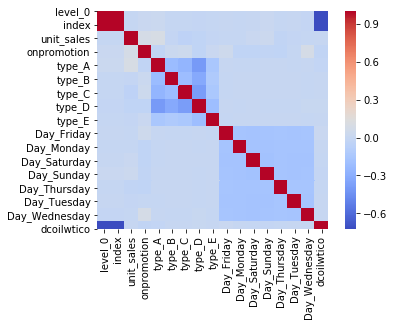

In [64]:
sns.heatmap(df_merged.corr(),square=True,cmap='coolwarm')